In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

import networkx.algorithms.community as comms

In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()
    
for i in range(len(data)):
    data[i] = 'p' + data[i] # adds 'p' to the People nodes to differentiate them

In [4]:
B = nx.read_edgelist(data)
graph = np.loadtxt(DATA, dtype=str)
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, name=name[j], sex=sex[j]) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)

# add edges
i = 0
for edge in B.edges():
    G.add_edge(edge[0], edge[1], role=role[i]) # why role is in a list?
    i+=1

p_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} # people
c_nodes = set(G) - p_nodes # crimes

# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])

P 754 2127


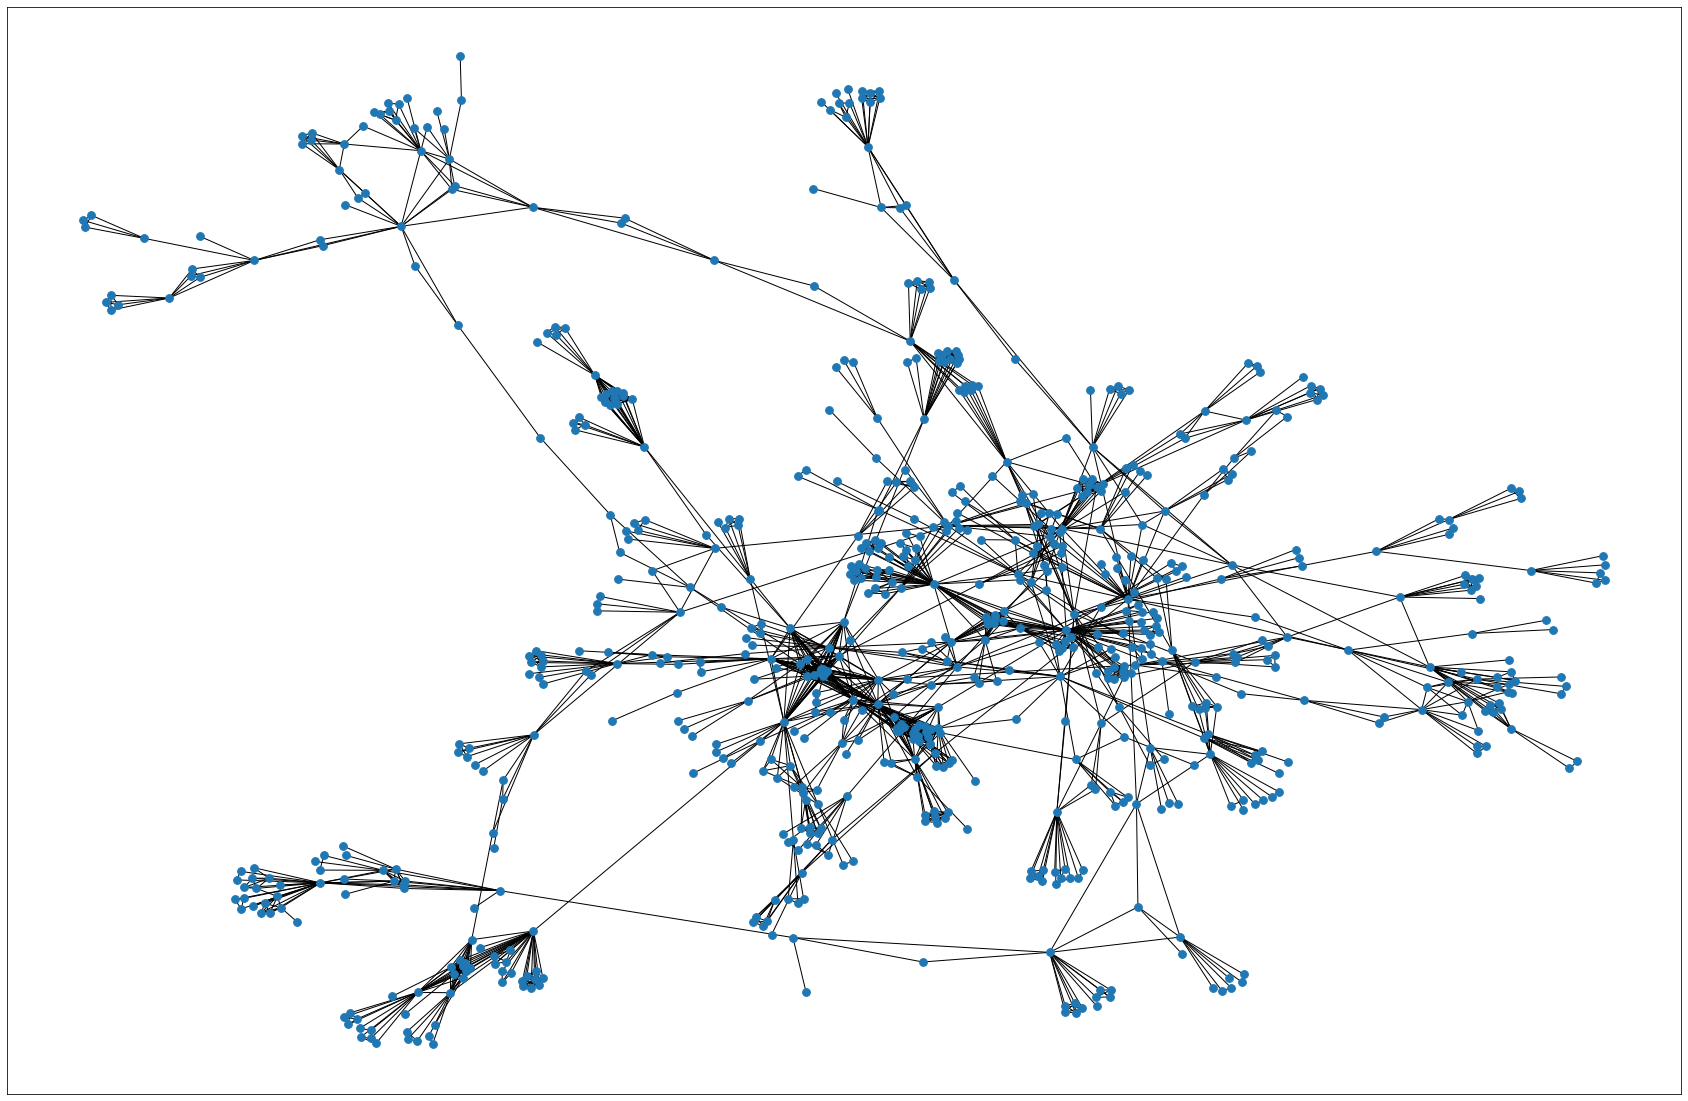

In [79]:
p_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_gcc = set(G0) - p_nodes_gcc

#print(len(p_nodes_gcc), len(c_nodes_gcc))

# project onto people and visualise
P = bipartite.weighted_projected_graph(G0, p_nodes_gcc)

print('P',len(P.nodes()), len(P.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, with_labels=False)

In [7]:
communities = sorted(comms.greedy_modularity_communities(P), key=len, reverse=True) #30 coms modularity 0.845
#communities = sorted(comms.label_propagation_communities(P), key=len, reverse=True) #89 coms modularity 0.787

# Count the communities
print(f"There are {len(communities)} communities.")

comms.modularity(P, communities)

There are 30 communities.


0.845226087349619

0 122
1 84
2 57
3 55
4 55
5 45
6 34
7 32
8 30
9 30


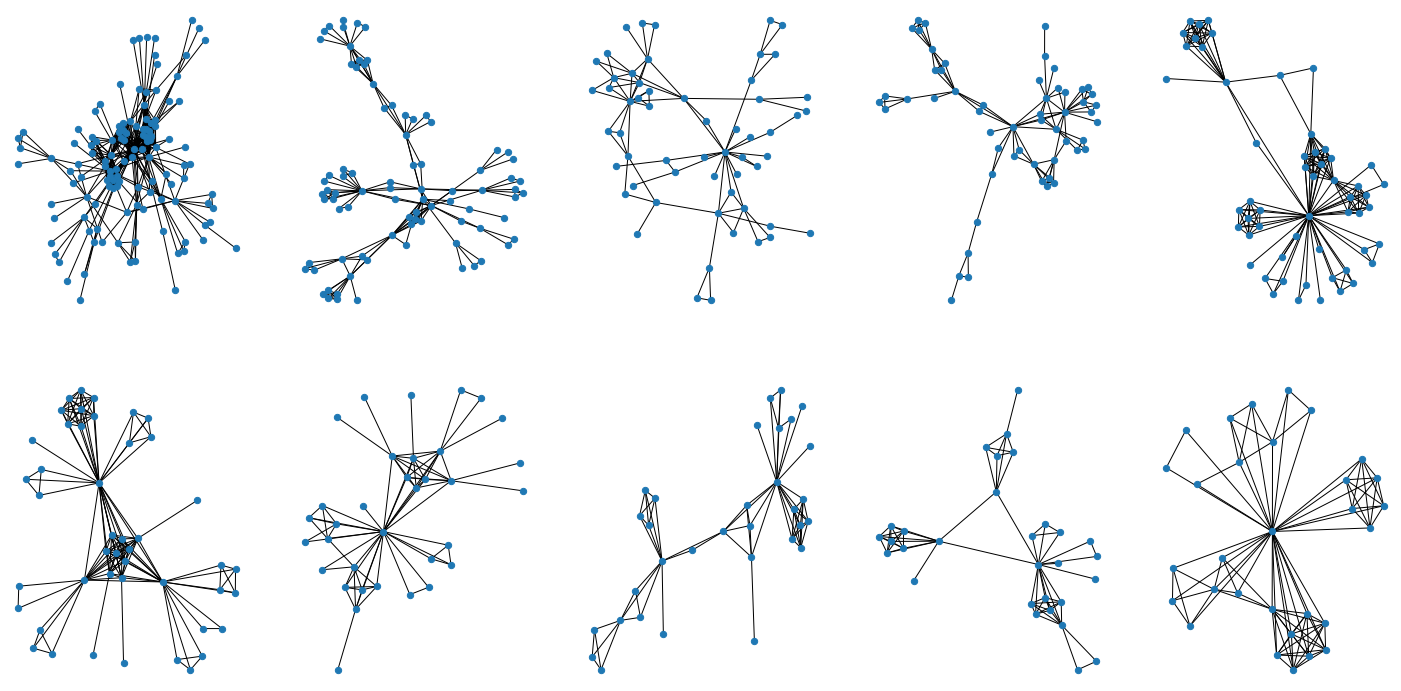

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,10): 
    comms = P.subgraph(communities[i])
    print(i, len(comms.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(comms, node_size=40) #, with_labels=True
plt.savefig(f'../Figures/1-10_community.jpg')

10 28
11 25
12 24
13 14
14 14
15 14
16 13
17 9
18 8
19 8


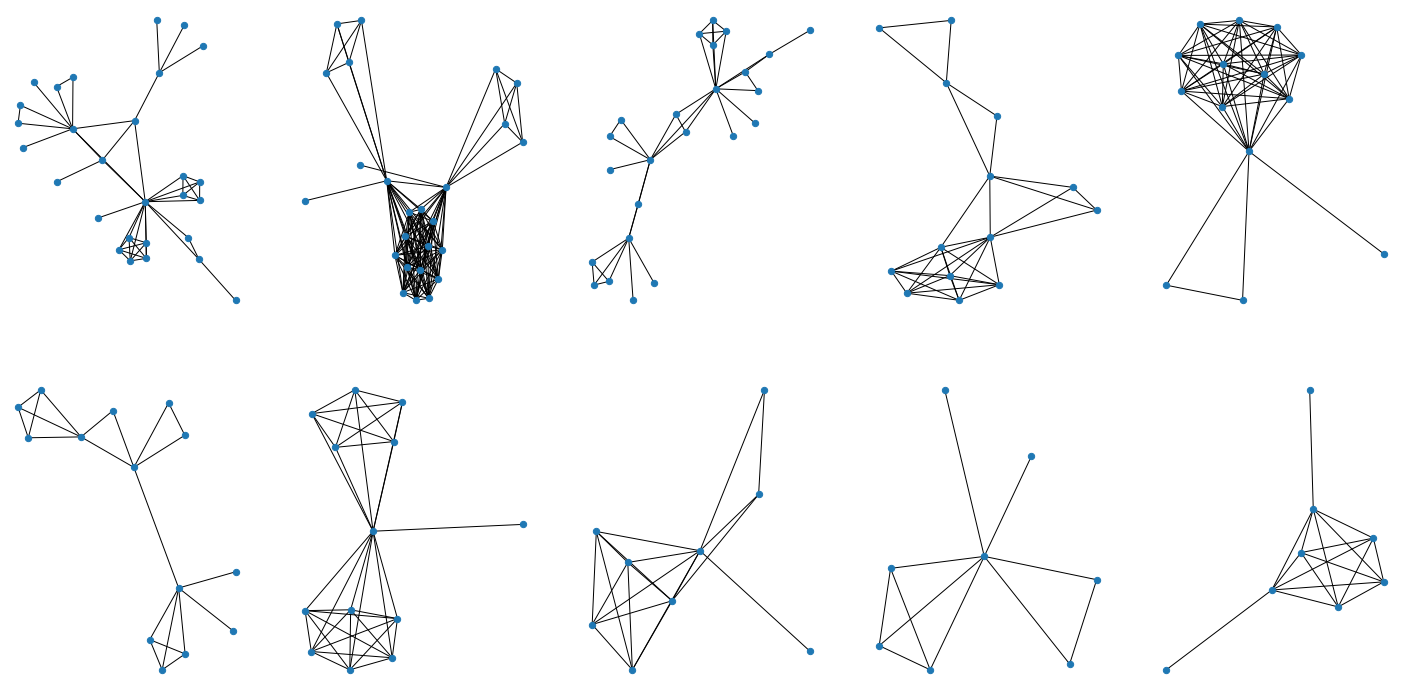

In [62]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(10,20): 
    comms = P.subgraph(communities[i])
    print(i, len(comms.nodes))
    plt.subplot(2,5,i-9)
    nx.draw_spring(comms, node_size=40)
plt.savefig(f'../Figures/11-20_community.jpg')

20 7
21 7
22 7
23 6
24 6
25 5
26 4
27 4
28 4
29 3


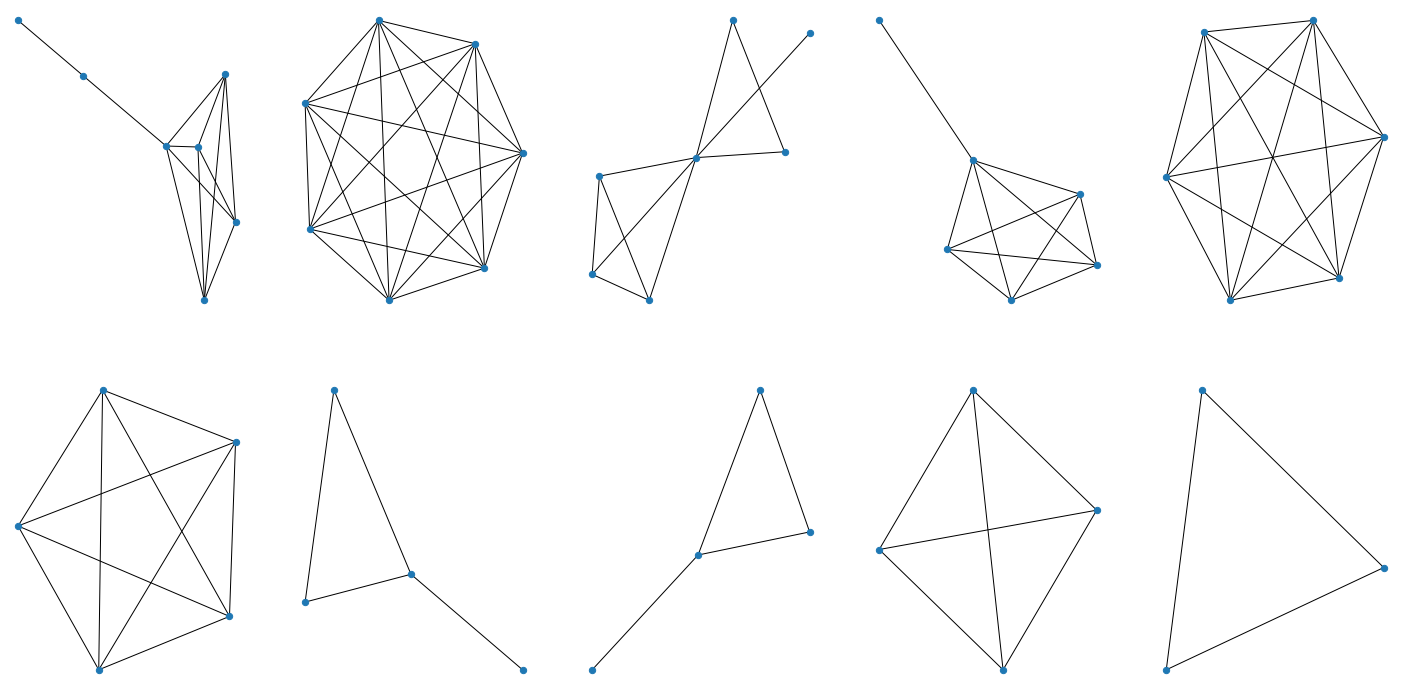

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(20,30): 
    comms = P.subgraph(communities[i])
    print(i, len(comms.nodes))
    plt.subplot(2,5,i-19)
    nx.draw_spring(comms, node_size=40)
plt.savefig(f'../Figures/21-30_community.jpg')

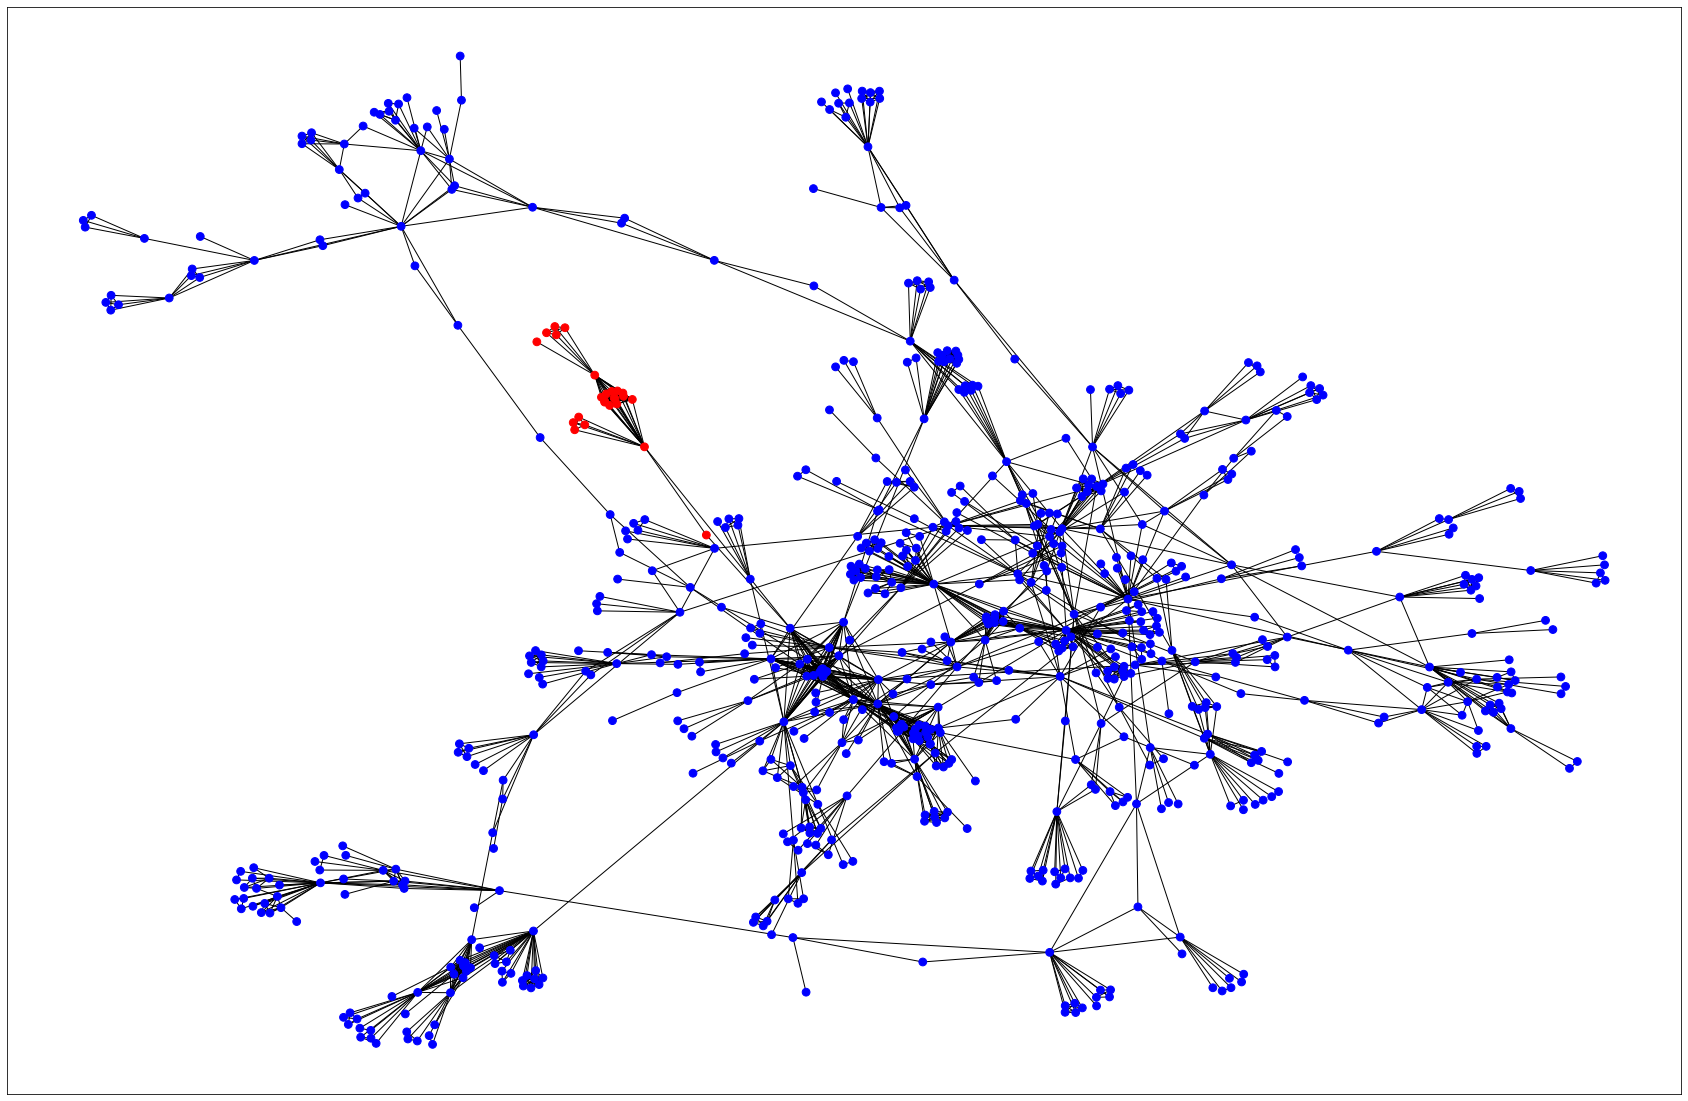

In [87]:
highlight = 11 #choose a community to highlight via it's index in the communities list

node_col = []

for node in P.nodes():
    if node in communities[highlight]:
        node_col.append('red')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, node_color=node_col, with_labels=False)

plt.savefig(f'../Figures/community_{highlight}_people_projec.jpg')

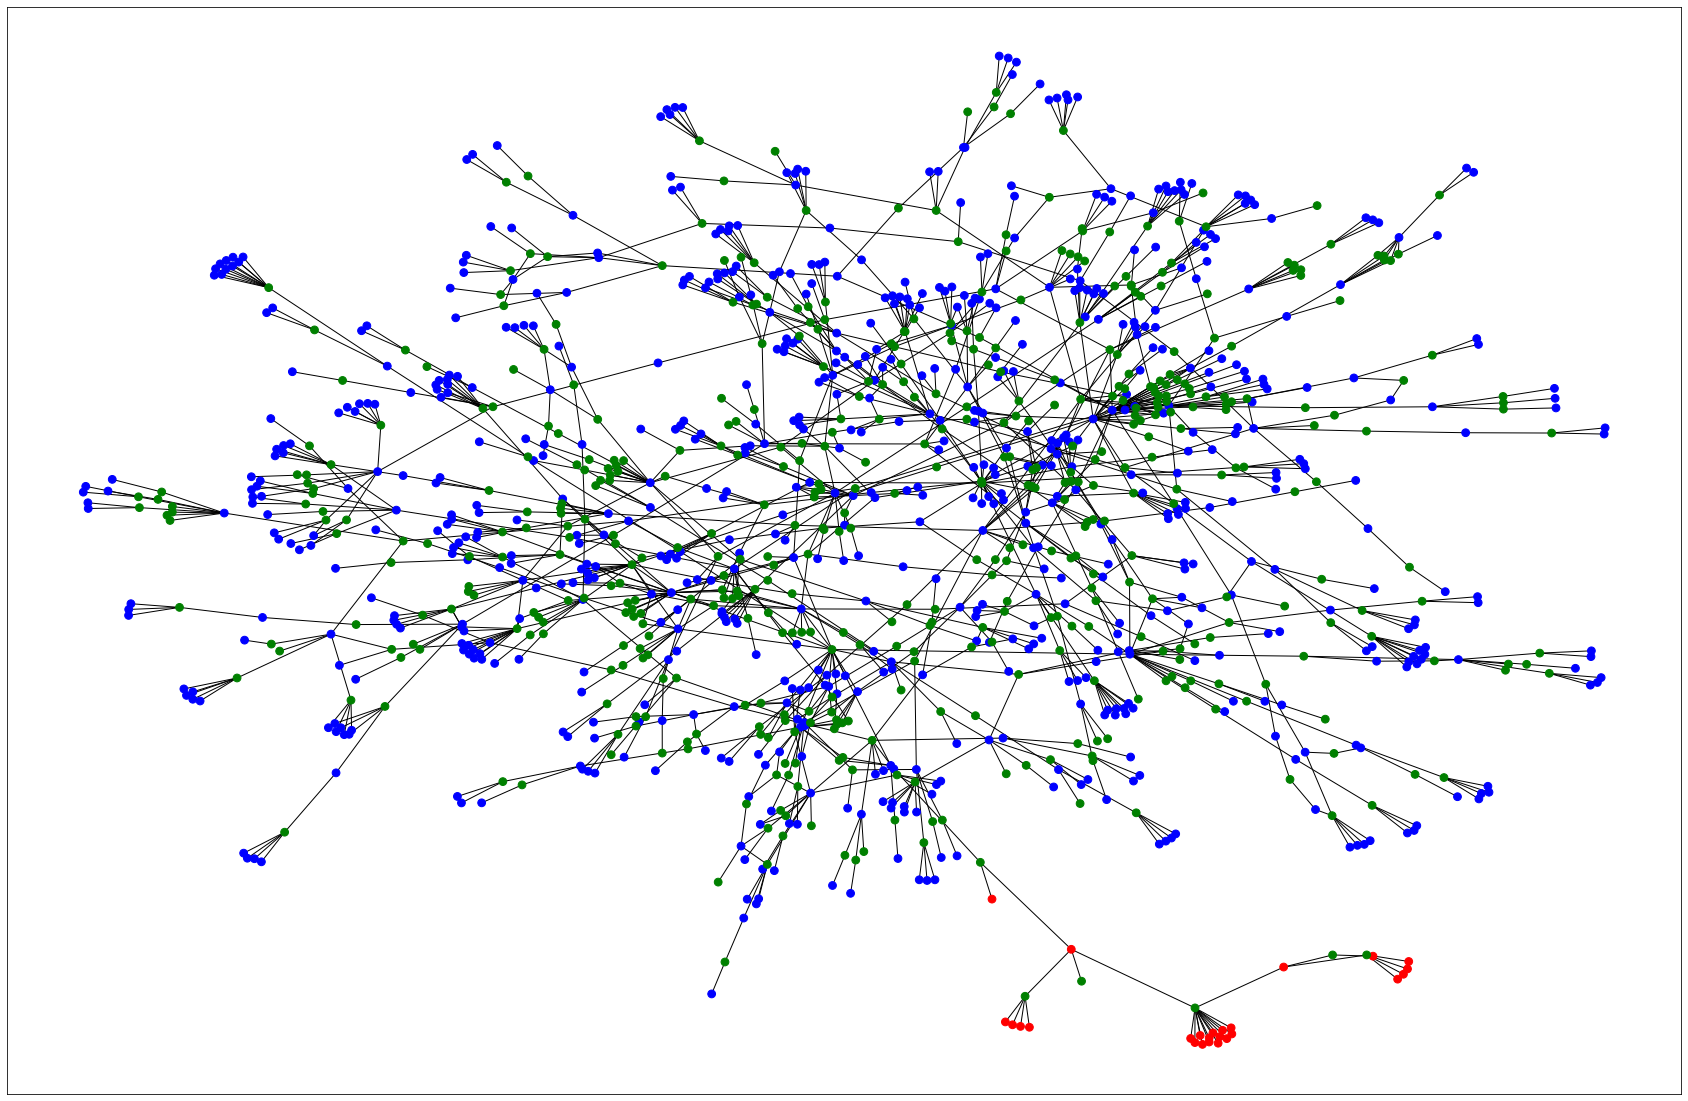

In [88]:
node_col = []

for node in G0.nodes():
    if node in communities[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)